In [1]:
%reload_ext autoreload
%autoreload
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from torch.cuda.amp import GradScaler, autocast

In [3]:
import seaborn as sns
import albumentations as A
from tqdm.notebook import tqdm

## Load DataFrame with Pathing

In [4]:
df = pd.read_csv('data/POC_imagedata.csv')

In [5]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [6]:
#df = df.sample(1000)

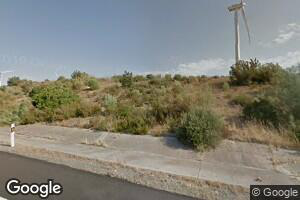

In [7]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [8]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [9]:
val, test = train_test_split(val, test_size=0.5, stratify=val.Country.values)

In [10]:
train.shape, val.shape, test.shape

((2400, 5), (300, 5), (300, 5))

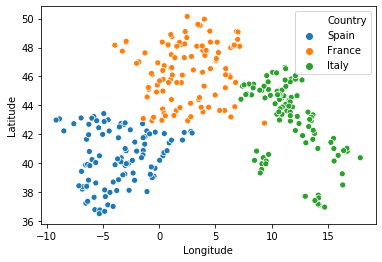

In [11]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [12]:
MAPPING = {'Spain': 0, # Spain
           'France': 1, # France
           'Italy': 2} # Italy

In [13]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [14]:
def stitch_panos(path, rand):
    direction = ['N','E','S','W']
    rolled = np.roll(direction, rand)
    top = np.concatenate([img_to_np(path + direction + '.jpg') for direction in rolled[:2]], axis=1)
    bottom = np.concatenate([img_to_np(path + direction + '.jpg') for direction in rolled[2:]], axis=1)
    return np.concatenate([top, bottom], axis=0)

In [15]:
def get_xy(path, y_map, rand):
    x = stitch_panos(path, rand)
    y = y_map[path[12: 12 + path[12:].find('/')]]
    return x, y

In [16]:
x, y = get_xy(train.Path.iloc[0], MAPPING, 1)

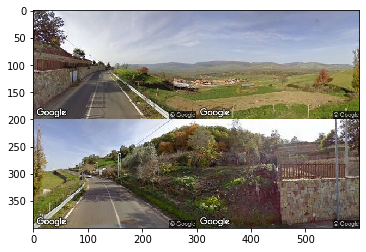

In [17]:
plt.imshow(x)

In [18]:
x.shape, y

((400, 600, 3), 2)

#### Data Augmentation Functions

In [19]:
transforms = A.Compose([
        A.Resize(400, 400),
        A.RandomCrop(height=350, width=350),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.25, rotate_limit=12.5, p=0.4),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.2),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.RandomCrop(height=350, width=350),
        A.Normalize()
])

In [20]:
def min_max_scale(img):
    max_, min_ = img.max(), img.min()
    return (img - min_) / (max_ - min_)

(350, 350, 3)


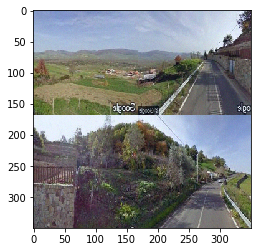

In [21]:
aug = transforms(image=x)['image']
print(aug.shape)
plt.imshow(min_max_scale(aug))

(350, 350, 3)


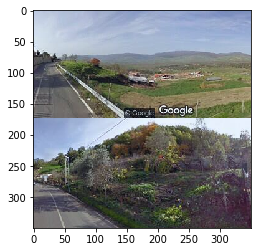

In [22]:
no_aug = no_transforms(image=x)['image']
print(no_aug.shape)
plt.imshow(min_max_scale(no_aug))

In [23]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.transform = transform
        self.random_init()
        
    def random_init(self):
        self.random = np.random.randint(4, size=len(self.paths))
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        x, y = get_xy(self.paths[idx], MAPPING, self.random[idx] + 1)
        
        if self.transform:
            x = transforms(image=x)['image']
        else:
            x = no_transforms(image=x)['image']
        
        x = np.rollaxis(x, 2)
        return x, y

In [24]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)
test_ds = GeoDataset(test)

In [25]:
x, y = train_ds[1]
x.shape, y

((3, 350, 350), 2)

## Model

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 3))
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(self.dropout(x))
        return x

In [27]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y, reduction='sum')
            _, pred = torch.max(out, 1)
            correct += pred.eq(y).sum().item()
            sum_loss += loss.item()
            total += batch
    return sum_loss/total, correct/total

In [28]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    pbar = tqdm(total=iterations)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    scaler = GradScaler()
    prev_val_acc = 0.0
    path = ''
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/20, lr/10, lr])
            batch = y.shape[0]
            
            optimizer.zero_grad()
            with autocast():
                x = x.cuda()
                y = y.cuda()
                out = model(x)
                loss = F.cross_entropy(out, y, reduction='sum')
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            #loss.backward()
            #optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
            pbar.update()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "data/models/model_resnet18_stitch_loss_{0:.0f}.pth".format(100*val_acc)
                save_model(model, path)
                print(path)
    return path

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [30]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [31]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/20},
              {'params': model.features2.parameters(), 'lr': lr0/10},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=9e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [32]:
batch_size = 96
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [33]:
model = Net().cuda()

In [34]:
val_metrics(model, valid_dl)

(1.1307302570343019, 0.3333333333333333)

In [35]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.01, epochs=25)

train_loss 1.085 val_loss 0.948 val_acc 0.583
train_loss 0.896 val_loss 0.857 val_acc 0.610
train_loss 0.761 val_loss 0.911 val_acc 0.650
train_loss 0.724 val_loss 0.766 val_acc 0.670
train_loss 0.710 val_loss 1.078 val_acc 0.607
train_loss 0.690 val_loss 0.869 val_acc 0.633
train_loss 0.777 val_loss 1.987 val_acc 0.543
train_loss 0.680 val_loss 0.954 val_acc 0.637
train_loss 0.665 val_loss 0.943 val_acc 0.563
train_loss 0.607 val_loss 0.881 val_acc 0.690
train_loss 0.627 val_loss 1.831 val_acc 0.577
train_loss 0.591 val_loss 1.308 val_acc 0.643
train_loss 0.539 val_loss 0.893 val_acc 0.607
train_loss 0.452 val_loss 0.721 val_acc 0.680
train_loss 0.436 val_loss 1.154 val_acc 0.670
train_loss 0.369 val_loss 0.871 val_acc 0.697
train_loss 0.308 val_loss 0.816 val_acc 0.713
train_loss 0.279 val_loss 0.793 val_acc 0.753
data/models/model_resnet18_stitch_loss_75.pth
train_loss 0.219 val_loss 0.975 val_acc 0.733
train_loss 0.187 val_loss 1.199 val_acc 0.680
train_loss 0.143 val_loss 1.126 va

In [36]:
best_path

'data/models/model_resnet18_stitch_loss_76.pth'

## Test Set Evaluation

In [37]:
best_model = Net().cuda()
load_model(best_model, best_path)

In [38]:
test.head()

,Country,Latitude,Longitude,Pano_Id,Path
2072,Italy,41.794881,12.254498,7XDnijj8DTMii60saTcyTw,data/images/Italy/0072/
2624,Italy,41.304297,13.500051,eiagymQ0McUosDdUv8GJPQ,data/images/Italy/0624/
2854,Italy,43.455476,13.236367,Dn-Xm9ZR2LeWaQlwpByFnw,data/images/Italy/0854/
841,Spain,41.964347,-3.023520,Xo4hJx5-SpaeoqEQIfJWdA,data/images/Spain/0841/
455,Spain,42.639432,-4.437176,0mpwWa2HbdOJj3-PEwzCCA,data/images/Spain/0455/


In [39]:
rev_map = {v: k for k,v in MAPPING.items()}
rev_map

{0: 'Spain', 1: 'France', 2: 'Italy'}

In [40]:
preds = []
with torch.no_grad():
    best_model.eval()
    for x, y in test_dl:
        out = best_model(x.cuda().float())
        _, pred = torch.max(out, 1)
        pred = pred.cpu().detach().numpy()
        preds += [rev_map[p] for p in pred]

In [41]:
test['predictions'] = preds

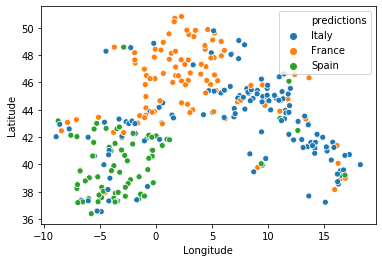

In [42]:
sns.scatterplot(x='Longitude', y='Latitude', data=test, hue='predictions')

In [43]:
(test.Country == test.predictions).sum() / len(test)

0.6966666666666667